ProductFamily


In [1]:
#Install the needed modules
#! pip install mlxtend
#! pip install networkx
#! pip install pyvis
#! pip install efficient-apriori
#! pip install folium
#! pip install mplleaflet
#! pip install geopy

In [2]:
# Import packages
import csv
import pandas as pd
import numpy as np
import datetime as dt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import matplotlib.ticker as mtick
import mplleaflet

%matplotlib inline

#Set better display options for the notebook.

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

C:\Users\PULSE Electronics\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\PULSE Electronics\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
# Load and show dataset sample (Chain of Asian Restaurant sales January 2018)
dtypes = {'DocNumber':'category','ProductDesignation':'category', 'ProductFamily':'category', 'Qty':'int'
          , 'TotalAmount':'object', 'EmployeeID':'int', 'IsDelivery':'bool', 'Pax':'int', 'CustomerID':'int'
          , 'CustomerCity':'category'}
ds = pd.DataFrame(pd.read_csv("AsianRestaurant_Cyprus_2018.txt",sep=";", dtype=dtypes, parse_dates=['InvoiceDateHour', 'CustomerSince']))

# Replace commas in TotalAmount column
ds['TotalAmount'] = ds['TotalAmount'].str.replace(',', '.')

# Convert TotalAmount to integer data type
ds['TotalAmount'] = ds['TotalAmount'].astype(float)

ds.head()

,DocNumber,ProductDesignation,ProductFamily,Qty,TotalAmount,InvoiceDateHour,EmployeeID,IsDelivery,Pax,CustomerID,CustomerCity,CustomerSince
0,TKD0320000012018,1/2 DUCK,STARTERS,1,27.1,2018-01-01 19:12:12,2,True,1,53908,LEYKOSIA,NaT
1,TKD0320000012018,SPRING ROLL,STARTERS,8,17.6,2018-01-01 19:12:12,2,True,1,53908,LEYKOSIA,NaT
2,TKD0320000012018,SWEET SOUR CHICKEN,MEAT,2,20.2,2018-01-01 19:12:12,2,True,1,53908,LEYKOSIA,NaT
3,TKD0320000012018,LEMON CHICKEN,MEAT,1,10.1,2018-01-01 19:12:12,2,True,1,53908,LEYKOSIA,NaT
4,TKD0320000012018,BEEF BBS,SIZZLING,1,12.6,2018-01-01 19:12:12,2,True,1,53908,LEYKOSIA,NaT


In [4]:
# Check missing values
datetime_is_numeric=True
print(ds.isnull().sum())

# Create Dataset statistics to check insights
datetime_is_numeric=True
print(ds.describe(include='all'))

DocNumber                 0
ProductDesignation        0
ProductFamily             0
Qty                       0
TotalAmount               0
InvoiceDateHour           0
EmployeeID                0
IsDelivery                0
Pax                       0
CustomerID                0
CustomerCity          52861
CustomerSince         54967
dtype: int64
              DocNumber   ProductDesignation ProductFamily           Qty   TotalAmount      InvoiceDateHour    EmployeeID IsDelivery           Pax    CustomerID CustomerCity               CustomerSince
count             84109                84109         84109  84109.000000  84109.000000                84109  84109.000000      84109  84109.000000  84109.000000        31248                       29142
unique            11147                  255            27           NaN           NaN                11146           NaN          2           NaN           NaN           17                        2109
top     TK0110044742018  MINERAL WATER 1.5LT 

C:\Users\PULSE Electronics\AppData\Local\Temp\ipykernel_12128\4259107620.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(ds.describe(include='all'))
C:\Users\PULSE Electronics\AppData\Local\Temp\ipykernel_12128\4259107620.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(ds.describe(include='all'))


# Data Exploration

In [5]:
family_counts = ds['ProductFamily'].value_counts()
family_counts

STARTERS       14148
DRINKS         11585
RICE           10720
MEAT            8561
EXTRAS          5044
SIZZLING        5028
JAP SUSHI       3900
MAIN IND        3060
WHITE WINE      2432
DESSERT         2372
SPIRITS         2067
TSANTES         1797
BREADS IND      1741
START IND       1704
SUSHI           1487
RICE IND        1424
RED WINES       1247
HOLDS           1184
SOUPS           1181
VEG IND          902
SEAFOOD          868
VEG              461
WITH             351
ROSE WINES       339
NEW SUSHI        281
SIDE IND         162
DESSERT IND       63
Name: ProductFamily, dtype: int64

In [6]:
#We wanted to create a dataframe to see what unique products and average and total quantatity of the products in the menu provided is
#ProductFamily: The unique product families in the dataset.
#Num_Unique_Products: The number of unique products in each product family.
#Avg_Quantity: The average quantity of products sold in each product family.
#Total_Quantity: The total quantity of products sold in each product family.

# Group the dataset by ProductFamily
grouped_by_family = ds.groupby('ProductFamily')

# Compute the statistics for each family
family_summary = grouped_by_family.agg(
    num_unique_products=pd.NamedAgg(column='ProductDesignation', aggfunc=lambda x: x.nunique()),
    avg_quantity=pd.NamedAgg(column='Qty', aggfunc='mean'),
    total_quantity=pd.NamedAgg(column='Qty', aggfunc='sum'),
)

# Sort the summary by the number of unique products in each family
family_summary = family_summary.sort_values(by='num_unique_products', ascending=False)

# Reset the index and rename the columns for better readability
family_summary.reset_index(inplace=True)
family_summary.columns = ['ProductFamily', 'Num_Unique_Products', 'Avg_Quantity', 'Total_Quantity']

# Display the family_summary DataFrame
print(family_summary.head(50))

   ProductFamily  Num_Unique_Products  Avg_Quantity  Total_Quantity
0     WHITE WINE                   30      1.113487            2708
1         DRINKS                   25      1.173241           13592
2      RED WINES                   21      1.137129            1418
3      JAP SUSHI                   17      1.072564            4183
4        SPIRITS                   17      1.326076            2741
5       STARTERS                   16      1.726817           24431
6       SIZZLING                   14      1.047932            5269
7           MEAT                   13      1.077678            9226
8      START IND                   11      1.193075            2033
9           RICE                   11      1.112687           11928
10         HOLDS                   10      1.044764            1237
11      MAIN IND                   10      1.107516            3389
12       DESSERT                    8      1.282040            3041
13       VEG IND                    7      1.029

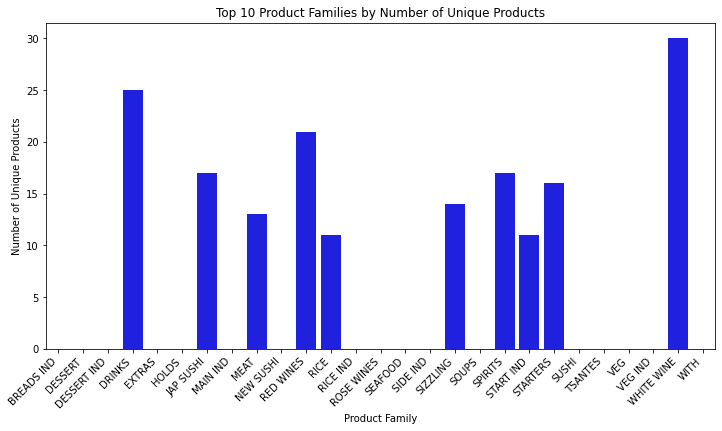

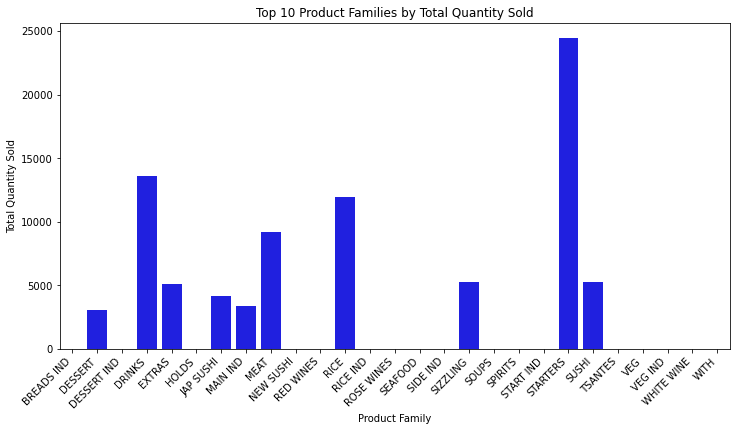

In [7]:
# Top 10 product families by the number of unique products
top_10_unique_products = family_summary.nlargest(10, 'Num_Unique_Products')

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_unique_products, x='ProductFamily', y='Num_Unique_Products', color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Product Families by Number of Unique Products')
plt.xlabel('Product Family')
plt.ylabel('Number of Unique Products')
plt.show()

# Top 10 product families by total quantity sold
top_10_total_quantity = family_summary.nlargest(10, 'Total_Quantity')

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_total_quantity, x='ProductFamily', y='Total_Quantity', color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Product Families by Total Quantity Sold')
plt.xlabel('Product Family')
plt.ylabel('Total Quantity Sold')
plt.show()

In [8]:
def map_product_family(family):
    if family in ['WHITE WINE', 'RED WINES', 'ROSE WINES']:
        return 'Wines'
    elif family in ['DRINKS', 'SPIRITS']:
        return 'Drinks'
    elif family in ['JAP SUSHI', 'SUSHI']:
        return 'Sushi'
    elif family in ['STARTERS', 'START IND']:
        return 'Starters'
    elif family in ['DESSERT', 'DESSERT IND']:
        return 'Desserts'
    else:
        return family

# Apply the mapping function to the dataset
ds['NewProductFamily'] = ds['ProductFamily'].apply(map_product_family)

# Display the new groupings
new_family_counts = ds['NewProductFamily'].value_counts()
print(new_family_counts)

Starters      15852
Drinks        13652
RICE          10720
MEAT           8561
Sushi          5387
EXTRAS         5044
SIZZLING       5028
Wines          4018
MAIN IND       3060
Desserts       2435
TSANTES        1797
BREADS IND     1741
RICE IND       1424
HOLDS          1184
SOUPS          1181
VEG IND         902
SEAFOOD         868
VEG             461
WITH            351
NEW SUSHI       281
SIDE IND        162
Name: NewProductFamily, dtype: int64


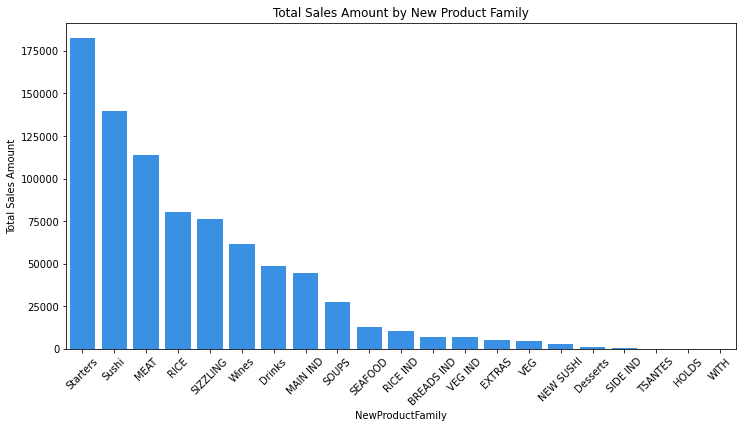

In [9]:
# Group the dataset by the new product family and calculate the total sales amount
sales_by_new_family = ds.groupby('NewProductFamily')['TotalAmount'].sum().reset_index()

# Sort the data by the total sales amount
sales_by_new_family = sales_by_new_family.sort_values('TotalAmount', ascending=False)

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=sales_by_new_family, x='NewProductFamily', y='TotalAmount', color='dodgerblue')
plt.title('Total Sales Amount by New Product Family')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.show()

In [10]:
ds_original = ds.copy()

filter_1 = (
    (ds['Qty'] <= 4) &
    (ds['TotalAmount'] <= 100) &
    (ds['Pax'] <= 16)
)

ds_1 = ds_original[filter_1]
percentage = (ds_1.shape[0] / ds_original.shape[0]) * 100
print(f'Percentage of data kept after removing outliers in ds_1: {percentage:.2f}%')

Percentage of data kept after removing outliers in ds_1: 97.90%


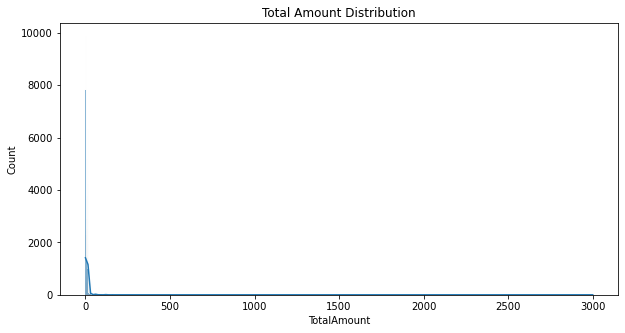

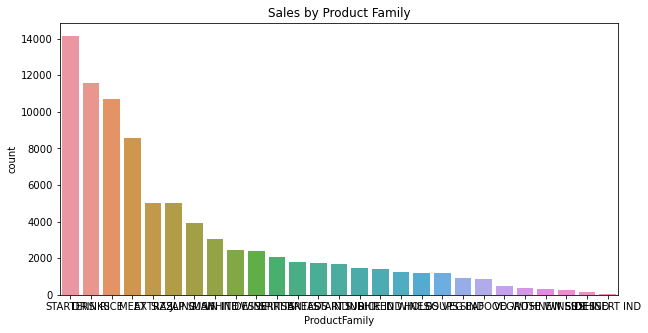

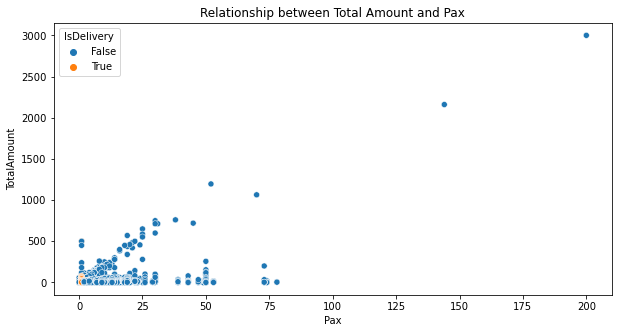

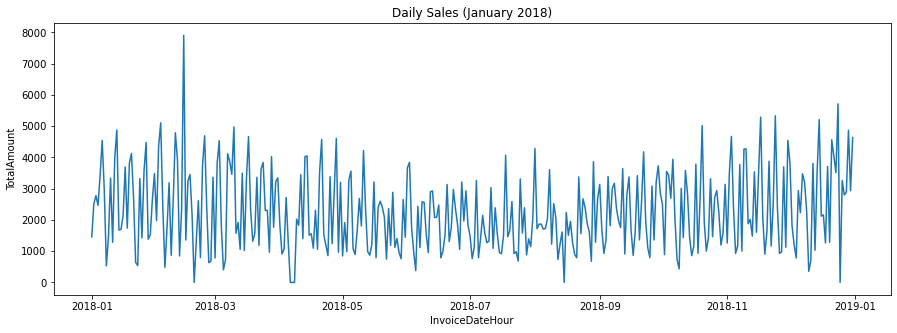

In [11]:
# Distribution of TotalAmount
plt.figure(figsize=(10, 5))
sns.histplot(data=ds, x='TotalAmount', kde=True)
plt.title('Total Amount Distribution')
plt.show()

# Sales by ProductFamily
plt.figure(figsize=(10, 5))
sns.countplot(data=ds, x='ProductFamily', order=ds['ProductFamily'].value_counts().index)
plt.title('Sales by Product Family')
plt.show()


# Relationship between TotalAmount and Pax
plt.figure(figsize=(10, 5))
sns.scatterplot(data=ds, x='Pax', y='TotalAmount', hue='IsDelivery')
plt.title('Relationship between Total Amount and Pax')
plt.show()

# Time series of sales
ds_daily = ds.resample('D', on='InvoiceDateHour').sum()
plt.figure(figsize=(15, 5))
sns.lineplot(data=ds_daily, x='InvoiceDateHour', y='TotalAmount')
plt.title('Daily Sales (January 2018)')
plt.show()

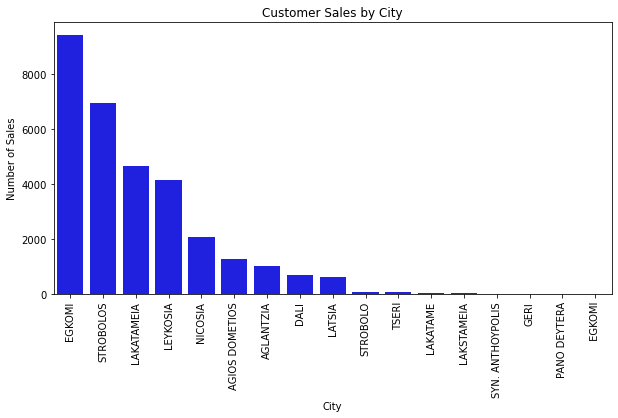

In [12]:
plt.figure(figsize=(10, 5))
sns.countplot(data=ds, x='CustomerCity', order=ds['CustomerCity'].value_counts().index, color='blue')
plt.title('Customer Sales by City')
plt.xlabel('City')
plt.ylabel('Number of Sales')
plt.xticks(rotation=90)
plt.show()

In [13]:
# Pivot the data - lines as documents and products as columns
#pt = pd.pivot_table(ds, index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt = pd.pivot_table(ds_1, index='DocNumber', columns='ProductDesignation', values='Qty', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt.head(20)

ProductDesignation,EXTRA PANCAKES,EXTRA SALAD,EXTRA SAUCE,NO BEANSPROUTS,NO CHILLY,NO EGG,NO MEAT,NO MUSHROOMS,NO ONION,NO PORK,NO PRAWNS,NO SAUCE,WITH BEEF,WITH CHICKEN,WITH PORK,WITH SHRIMP,1/2 DUCK,1/4 DUCK,1/6 DUCK,7UP,AG. ANDRONIKOS 37.5CL WHITE,AGIOS ELIAS 37.5CL RED,AGIOS OUNOFRIOS RED,ALOO BAINGAN,ALOO PALAK,ANDESITIS RED,APPLE JUICE,ASSORTED PICKLES,AVOCADO MAKI,AYIOKILIMA WHITE,AYIOS ANDRONIKOS 37.5CL,AYIOS ANDRONIKOS XYNISTERI,BABATZIM ERODIOS ROSE,BABY PORK,BBQ SPARE RIBS,BEEF BBS,BEEF OYSTER SAUCE,BEEF PEPPER SAUCE,BEEF WITH GINGER,BIBLIA CHORA RED,BIBLIA CHORA ROSE,BIBLIA CHORA WHITE,BOUTARI MOSCHOFILERO WHITE,BUFFET SUSHI,BUTTER CHICKEN,CALIFORNIA MAKI,CARLSBERG 33CL,CARRAT HALWA,CARROT HALWA,CAULIFLOWER GUNCHAO,CHASING THE DRAGON,CHATEAU LAZARIDES RED,CHATEAU LAZARIDI WHITE,CHICK KORMA KASHMIRI,CHICK TIKKA BHUNA,CHICK TIKKA MASALA,CHICKEN BBS,CHICKEN CANTONESE STYLE,CHICKEN CASHEW NUTS,CHICKEN GREEN PEPPERS,CHICKEN KALIMIRCH TIKKA,CHICKEN MIXED VEGETABLES,CHICKEN OYSTER SAUCE,CHICKEN SATAY,CHICKEN TIKKA,CHICKEN VINDALOO,CHICKEN WITH GINGER,CHICKEN WITH MUSHROOMS,CHINESE BEER 33CL,CHIVAS,CHOW MEIN BEEF,CHOW MEIN CHICKEN,CLASSIC ROLLS CUCUMBER,CLASSIC ROLLS VEG,COFFEE COMPLIMENTARY,COKE,COKE ZERO,COMMANDARIA 5CL,COURVOISIER COGNAC,CRISPY AROMATIC DUCK,CROUCHING TIGER,CUCUMBER MAKI,CURRY,CYPRUS COFFEE,DELIVERY CHARGE,DESSERT,DIET 7UP,DIET COKE,DIET SPRITE,DOUREIOS ERYTHROS,DRAGON MAKI,DRINK,DRY FRUIT SAFFRON,DUO TANDOORI FLOWERS,EBI SUSHI,EEL MAKI,EGG FRIED RICE,ENGLISH TEA,ESPRESSO,EVAMBELOS RED,FAMOUS,FANTA,FILTER COFFEE,FOOD,FORTANT CABERNET,FORTUNE PORK,FRASCATI DI PAPA WHITE,FRIED SHREDDED BEEF,FRUIT JUICE 30CL,FUTO MAKI,GEROVASILIOU RED,GLASS RED WINE,GLASS WHITE WINE,GLASS WINE ROSE,HADJIMICHALI LEFKOS,HENNESSY COGNAC,HOT AND SOUR SOUP,ICE CREAM,IMPORTED BEER 33CL,INDIAN BUFFET,J&B,J.WALKER BLACK,J.WALKER RED,JASMINE TEA,JIRA PULAO,JUNGLEE MANS,KADHAI BHINDI,KEO,KTHMA GEROVASSILIOU WHITE,KTIMA GEROVASSILIOU WHITE,KTIMA MALLIA RED,KYPEROUNDAS CHARDONNAY,KYPEROUNDAS RED,LAMB ROGAN JOSH,LEMON CHICKEN,LEVANDA ROSE,LYCHEES,LYCHEES COMPLIMENTARY,MAKKAS ROSE,MALAGOUZIA BOUTARI,MALAGOUZIA ROXANIS MATSA,MALAI MANGO CHICK,MALVASIA ROSE,MARATHEFTIKO RED,MATEUS 37.5CL,MATEUS ROSE,MEEN MOILEE,MINERAL WATER 1.5LT,MINT RAITA,MIX VEG,MIX VEG MAKI,MIX VEG OYSTER,MIXED PLATTER SUSHI,MOET CHANDON BRUT,MONTLY WINES,NAAN,NESCAFE,NOODLES BEAN SPROUTS,NOODLES MUSHROOM SOUP,NOODLES WITH MEAT,ONION BADJI,ORANGE JUICE,PALAK PANEER,PANEER MAKHNI,PAPAIOANNOU AGIORGITIKO RED,PECKING STYLE PRAWNS,PERRIER,PERSEFONI KOLIOS WHITE,PESHWARI NAAN,PETRITIS KYPEROUNDA,PHILADELPHIA MAKI,PINOT GRIGIO WHITE,POACHED PEARS,POPPDUMS,PORK BBS,PORK OYSTER SAUCE,PORK WITH GINGER,PRAWN CRACKERS,PRAWN PURI,PRAWNS BBS,PRAWNS CASHEWNUTS,PRAWNS MIXED VEG,PRAWNS OYSTER SAUCE,PRAWNS WITH GINGER,ROSE KYPEROUNDAS,ROTI,SAKE 12CL,SALMON MAKI,SALMON SASHIMI,SALMON SUSHI,SALT PEPPER PRAWNS,SALT PEPPER SQUID,SAMOSA,SAMOSA CHICKEN,SANDORINI BOUTARI,SEAWEED,SELCTION FOR TWO,SESAME PRAWNS,SHRIMP FRIED RICE,SODA,SORBET,SORBET IND,SPECIAL BUFFET,SPECIAL MONTPARNASSE RICE,SPICY NOODLES,SPICY RICE,SPICY SALMON MAKI,SPICY SALMON SASHIMI,SPIRITS 5CL,SPRING ROLL,SPRITE,STEAMED RICE,STEAMED RICE IND,SWEET SOUR CHICKEN,SWEET SOUR PORK,SWEET SOUR PRAWNS,SWEETCORN SOUP,SZECHUAN PRAWNS,TANDOORI CHICK 1/2,TANDOORI CHICK WHOLE,TANDOORI TILL JHEENGA,TANDOORI TRILOGY,TEMPURA MAKI,THISBE WHITE,TIN JIAN STYLE CHICKEN,TOFFEE APPLE COMPLEMENTARY,TOFFEE APPLE ICECREAM,TOFFEE BANANA COMPLEMENTARY,TOFFEE BANANA ICECREAM,TONIC,TSANTA,VALENTINES BUFET,VASSILIKON XYNISTERI,VEG BBS,VEG RICE,VELOUDO RED,VLASSIDES SHIRAZ,VOLCANO MAKI,WHISKY 17.5,WHISKY 37.5CL,WHISKY 5CL,WHISKY PREMIUM 5CL,WHOLE DUCK,WINE,YELLOW DAL DHABA,ZIVANIA 20CL,ZIVANIA 5CL,NO BABY CORN,BABATZIM KIOSK,MAURO PROVATO ROSE,MAURO PROVATO WHITE,MOSCHOFILERO BOUTARI,PAPAGIANNAKOS RED,PAPAGIANNAKOS WHITE
DocNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [14]:
ds_1['weekday'] = ds_1['InvoiceDateHour'].dt.weekday
ds_1['weekday_name'] = ds_1['InvoiceDateHour'].dt.day_name()

C:\Users\PULSE Electronics\AppData\Local\Temp\ipykernel_12128\3492020354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_1['weekday'] = ds_1['InvoiceDateHour'].dt.weekday
C:\Users\PULSE Electronics\AppData\Local\Temp\ipykernel_12128\3492020354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_1['weekday_name'] = ds_1['InvoiceDateHour'].dt.day_name()


In [15]:
# create a new column for lunch/dinner category
ds_1['time_period'] = ds_1['InvoiceDateHour'].apply(lambda x: 'Lunch' if x.hour < 16 else 'Dinner')

C:\Users\PULSE Electronics\AppData\Local\Temp\ipykernel_12128\2978224018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_1['time_period'] = ds_1['InvoiceDateHour'].apply(lambda x: 'Lunch' if x.hour < 16 else 'Dinner')


In [16]:
lunch_data = ds_1[ds_1['time_period'] == 'Lunch']
dinner_data = ds_1[ds_1['time_period'] == 'Dinner']

In [17]:
ds_1.describe()

,Qty,TotalAmount,EmployeeID,Pax,CustomerID,weekday
count,82339.000000,82339.000000,82339.000000,82339.000000,82339.000000,82339.000000
mean,1.175142,8.925505,3.603044,3.074958,12789.052891,3.530563
std,0.524501,8.888902,3.691481,2.553804,22036.633187,1.820078
min,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,2.000000,1.000000,0.000000,2.000000
50%,1.000000,6.900000,2.000000,2.000000,0.000000,4.000000
75%,1.000000,12.600000,5.000000,4.000000,18432.000000,5.000000
max,4.000000,100.000000,27.000000,16.000000,69101.000000,6.000000


In [18]:
lunch_data.describe()

,Qty,TotalAmount,EmployeeID,Pax,CustomerID,weekday
count,7852.000000,7852.000000,7852.000000,7852.000000,7852.000000,7852.000000
mean,1.199312,9.409117,5.264901,4.286806,6147.134870,4.771268
std,0.544431,7.411179,6.595921,2.988751,16860.460287,1.776852
min,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,1.000000,3.400000,2.000000,2.000000,0.000000,4.000000
50%,1.000000,7.900000,2.000000,4.000000,0.000000,6.000000
75%,1.000000,12.800000,5.000000,6.000000,0.000000,6.000000
max,4.000000,100.000000,27.000000,15.000000,69073.000000,6.000000


In [19]:
dinner_data.describe()

,Qty,TotalAmount,EmployeeID,Pax,CustomerID,weekday
count,74487.000000,74487.000000,74487.000000,74487.000000,74487.000000,74487.000000
mean,1.172594,8.874525,3.427860,2.947212,13489.206479,3.399774
std,0.522294,9.029132,3.186857,2.469165,22398.673696,1.774751
min,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,2.000000,1.000000,0.000000,2.000000
50%,1.000000,6.900000,2.000000,2.000000,0.000000,4.000000
75%,1.000000,12.600000,5.000000,4.000000,23793.000000,5.000000
max,4.000000,100.000000,27.000000,16.000000,69101.000000,6.000000


In [20]:
print(pt.columns)

CategoricalIndex([' EXTRA PANCAKES', ' EXTRA SALAD', ' EXTRA SAUCE',
                  ' NO BEANSPROUTS', ' NO CHILLY', ' NO EGG', ' NO MEAT',
                  ' NO MUSHROOMS', ' NO ONION', ' NO PORK',
                  ...
                  'YELLOW DAL DHABA', 'ZIVANIA 20CL', 'ZIVANIA 5CL',
                  ' NO BABY CORN', 'BABATZIM KIOSK', 'MAURO PROVATO ROSE',
                  'MAURO PROVATO WHITE', 'MOSCHOFILERO BOUTARI',
                  'PAPAGIANNAKOS RED', 'PAPAGIANNAKOS WHITE'],
                 categories=[' EXTRA PANCAKES', ' EXTRA SALAD', ' EXTRA SAUCE', ' NO BEANSPROUTS', ' NO CHILLY', ' NO EGG', ' NO MEAT', ' NO MUSHROOMS', ...], ordered=False, dtype='category', name='ProductDesignation', length=254)


In [21]:
# Check in how many documents was SPRING ROLL sold
pt['SPRING ROLL'].sum()

3204.0

In [22]:
# Apply the APRIORI algorithm
# Rules supported in at least 5% of the transactions (more info at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)
frequent_itemsets = apriori(pt, min_support=0.05, use_colnames=True)

C:\Users\PULSE Electronics\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [23]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
35,"(EGG FRIED RICE, NO MEAT)",(NOODLES WITH MEAT),0.056338,0.158451,0.056338,1.000000,6.311111,0.047411,inf
2,( NO MEAT),(NOODLES WITH MEAT),0.097057,0.158451,0.097057,1.000000,6.311111,0.081678,inf
39,"(MINERAL WATER 1.5LT, NO MEAT)",(NOODLES WITH MEAT),0.065637,0.158451,0.065637,1.000000,6.311111,0.055237,inf
66,"(EGG FRIED RICE, TOFFEE BANANA COMPLEMENTARY)",(MINERAL WATER 1.5LT),0.079902,0.511737,0.077013,0.963842,1.883471,0.036124,13.503521
74,"(SWEET SOUR CHICKEN, TOFFEE BANANA COMPLEMENTARY)",(MINERAL WATER 1.5LT),0.061845,0.511737,0.058685,0.948905,1.854282,0.027037,9.556003
34,(TOFFEE BANANA COMPLEMENTARY),(MINERAL WATER 1.5LT),0.177411,0.511737,0.165132,0.930789,1.818881,0.074344,7.054681
11,(BUFFET SUSHI),(MINERAL WATER 1.5LT),0.100939,0.511737,0.092904,0.920394,1.798567,0.041249,6.133460
24,(GLASS WHITE WINE),(MINERAL WATER 1.5LT),0.058324,0.511737,0.053359,0.914861,1.787755,0.023512,5.734870
16,(TSANTA),(DELIVERY CHARGE),0.157909,0.350939,0.136782,0.866209,2.468262,0.081366,4.851315
14,(COKE ZERO),(MINERAL WATER 1.5LT),0.096515,0.511737,0.083243,0.862488,1.685413,0.033853,3.550701


In [24]:
# Generate the association rules - by lift
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
rulesLift.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
39,"(MINERAL WATER 1.5LT, NOODLES WITH MEAT)",( NO MEAT),0.098140,0.097057,0.065637,0.668813,6.890954,0.056112,2.726387
40,( NO MEAT),"(MINERAL WATER 1.5LT, NOODLES WITH MEAT)",0.097057,0.098140,0.065637,0.676279,6.890954,0.056112,2.785918
35,"(EGG FRIED RICE, NOODLES WITH MEAT)",( NO MEAT),0.088389,0.097057,0.056338,0.637385,6.567142,0.047759,2.490089
36,( NO MEAT),"(EGG FRIED RICE, NOODLES WITH MEAT)",0.097057,0.088389,0.056338,0.580465,6.567142,0.047759,2.172908
34,"(EGG FRIED RICE, NO MEAT)",(NOODLES WITH MEAT),0.056338,0.158451,0.056338,1.000000,6.311111,0.047411,inf
38,"(MINERAL WATER 1.5LT, NO MEAT)",(NOODLES WITH MEAT),0.065637,0.158451,0.065637,1.000000,6.311111,0.055237,inf
41,(NOODLES WITH MEAT),"(MINERAL WATER 1.5LT, NO MEAT)",0.158451,0.065637,0.065637,0.414245,6.311111,0.055237,1.595142
0,( NO MEAT),(NOODLES WITH MEAT),0.097057,0.158451,0.097057,1.000000,6.311111,0.081678,inf
37,(NOODLES WITH MEAT),"(EGG FRIED RICE, NO MEAT)",0.158451,0.056338,0.056338,0.355556,6.311111,0.047411,1.464303
1,(NOODLES WITH MEAT),( NO MEAT),0.158451,0.097057,0.097057,0.612536,6.311111,0.081678,2.330390


Rules are in the form of "frozensets". Frozensets have functions to check if there are subsets, supersets, etc.
More info at https://www.journaldev.com/22850/python-frozenset

##### EXPLORE FREQUENT_ITEMSETS #####

In [25]:
# Add a column with the length
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

In [26]:
# Length=2 and Support>=0.2
frequent_itemsets[(frequent_itemsets['length'] == 2) & (frequent_itemsets['support'] >= 0.2)]


,support,itemsets,length
68,0.207205,"(MINERAL WATER 1.5LT, EGG FRIED RICE)",2
72,0.216956,"(SWEET SOUR CHICKEN, EGG FRIED RICE)",2


In [27]:
# Spring Roll and Coke
frequent_itemsets[ frequent_itemsets['itemsets'] == {'SPRING ROLL', 'MINERAL WATER 1.5LT'}]


,support,itemsets,length
82,0.14229,"(SPRING ROLL, MINERAL WATER 1.5LT)",2


In [28]:
# Coke
frequent_itemsets[ frequent_itemsets['itemsets'] == {'COKE'}]


,support,itemsets,length
10,0.056338,(COKE),1


In [29]:
# High Confidence and high Lift
rulesConfidence[(rulesConfidence['confidence'] >= 0.9) & (rulesConfidence['lift'] >= 4)]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
35,"(EGG FRIED RICE, NO MEAT)",(NOODLES WITH MEAT),0.056338,0.158451,0.056338,1.0,6.311111,0.047411,inf
2,( NO MEAT),(NOODLES WITH MEAT),0.097057,0.158451,0.097057,1.0,6.311111,0.081678,inf
39,"(MINERAL WATER 1.5LT, NO MEAT)",(NOODLES WITH MEAT),0.065637,0.158451,0.065637,1.0,6.311111,0.055237,inf


In [30]:
# High Confidence rules where "BEEF BBS" and "SPRING ROLL" are in the LHS
rulesConfidence[rulesConfidence['antecedents']=={'SPRING ROLL','BEEF BBS'}] # Because rules are a "frozenset" object, the order of items is not important


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [31]:
# High Confidence rules where "Sweet Sour Chick" is in the RHS
rulesConfidence[['SWEET SOUR CHICKEN' in elem for elem in rulesConfidence['consequents']]]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
68,"(EGG FRIED RICE, NOODLES WITH MEAT)",(SWEET SOUR CHICKEN),0.088389,0.320874,0.052004,0.588355,1.833603,0.023643,1.649788
64,"(EGG FRIED RICE, MINERAL WATER 1.5LT)",(SWEET SOUR CHICKEN),0.207205,0.320874,0.115204,0.555991,1.732740,0.048717,1.529533
70,"(SPRING ROLL, EGG FRIED RICE)",(SWEET SOUR CHICKEN),0.151047,0.320874,0.082972,0.549313,1.711926,0.034505,1.506867
23,(EGG FRIED RICE),(SWEET SOUR CHICKEN),0.400686,0.320874,0.216956,0.541460,1.687454,0.088386,1.481062
47,"(EGG FRIED RICE, 1/4 DUCK)",(SWEET SOUR CHICKEN),0.125677,0.320874,0.067533,0.537356,1.674665,0.027207,1.467925
56,"(EGG FRIED RICE, DELIVERY CHARGE)",(SWEET SOUR CHICKEN),0.147616,0.320874,0.077013,0.521713,1.625911,0.029647,1.419912
72,"(MINERAL WATER 1.5LT, NOODLES WITH MEAT)",(SWEET SOUR CHICKEN),0.098140,0.320874,0.051192,0.521619,1.625620,0.019701,1.419635
54,"(BEEF BBS, MINERAL WATER 1.5LT)",(SWEET SOUR CHICKEN),0.114933,0.320874,0.058415,0.508248,1.583950,0.021536,1.381034
52,"(BEEF BBS, EGG FRIED RICE)",(SWEET SOUR CHICKEN),0.135067,0.320874,0.067895,0.502674,1.566577,0.024555,1.365555


In [32]:
# Substitue products
rulesLift2 = association_rules(frequent_itemsets, metric="lift", min_threshold=0.0)
rulesLift2.sort_values(by='lift', ascending=True, inplace=True)
rulesLift2.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
32,(BEEF BBS),(DELIVERY CHARGE),0.201788,0.350939,0.064373,0.319016,0.909035,-0.006442,0.953122
33,(DELIVERY CHARGE),(BEEF BBS),0.350939,0.201788,0.064373,0.183432,0.909035,-0.006442,0.977521
94,(SPRING ROLL),(MINERAL WATER 1.5LT),0.289274,0.511737,0.142290,0.491885,0.961207,-0.005743,0.960930
95,(MINERAL WATER 1.5LT),(SPRING ROLL),0.511737,0.289274,0.142290,0.278052,0.961207,-0.005743,0.984456
12,(MINERAL WATER 1.5LT),(1/4 DUCK),0.511737,0.217226,0.108252,0.211538,0.973815,-0.002911,0.992786
13,(1/4 DUCK),(MINERAL WATER 1.5LT),0.217226,0.511737,0.108252,0.498337,0.973815,-0.002911,0.973290
88,(MINERAL WATER 1.5LT),(NAAN),0.511737,0.118725,0.059498,0.116267,0.979293,-0.001258,0.997218
89,(NAAN),(MINERAL WATER 1.5LT),0.118725,0.511737,0.059498,0.501141,0.979293,-0.001258,0.978759
176,"(SPRING ROLL, EGG FRIED RICE)",(DELIVERY CHARGE),0.151047,0.350939,0.052004,0.344292,0.981059,-0.001004,0.989862
181,(DELIVERY CHARGE),"(SPRING ROLL, EGG FRIED RICE)",0.350939,0.151047,0.052004,0.148186,0.981059,-0.001004,0.996641


### Plot a basic network graph of the top 30 confidence rules

In [33]:
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rulesConfidence.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]

In [34]:
# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)

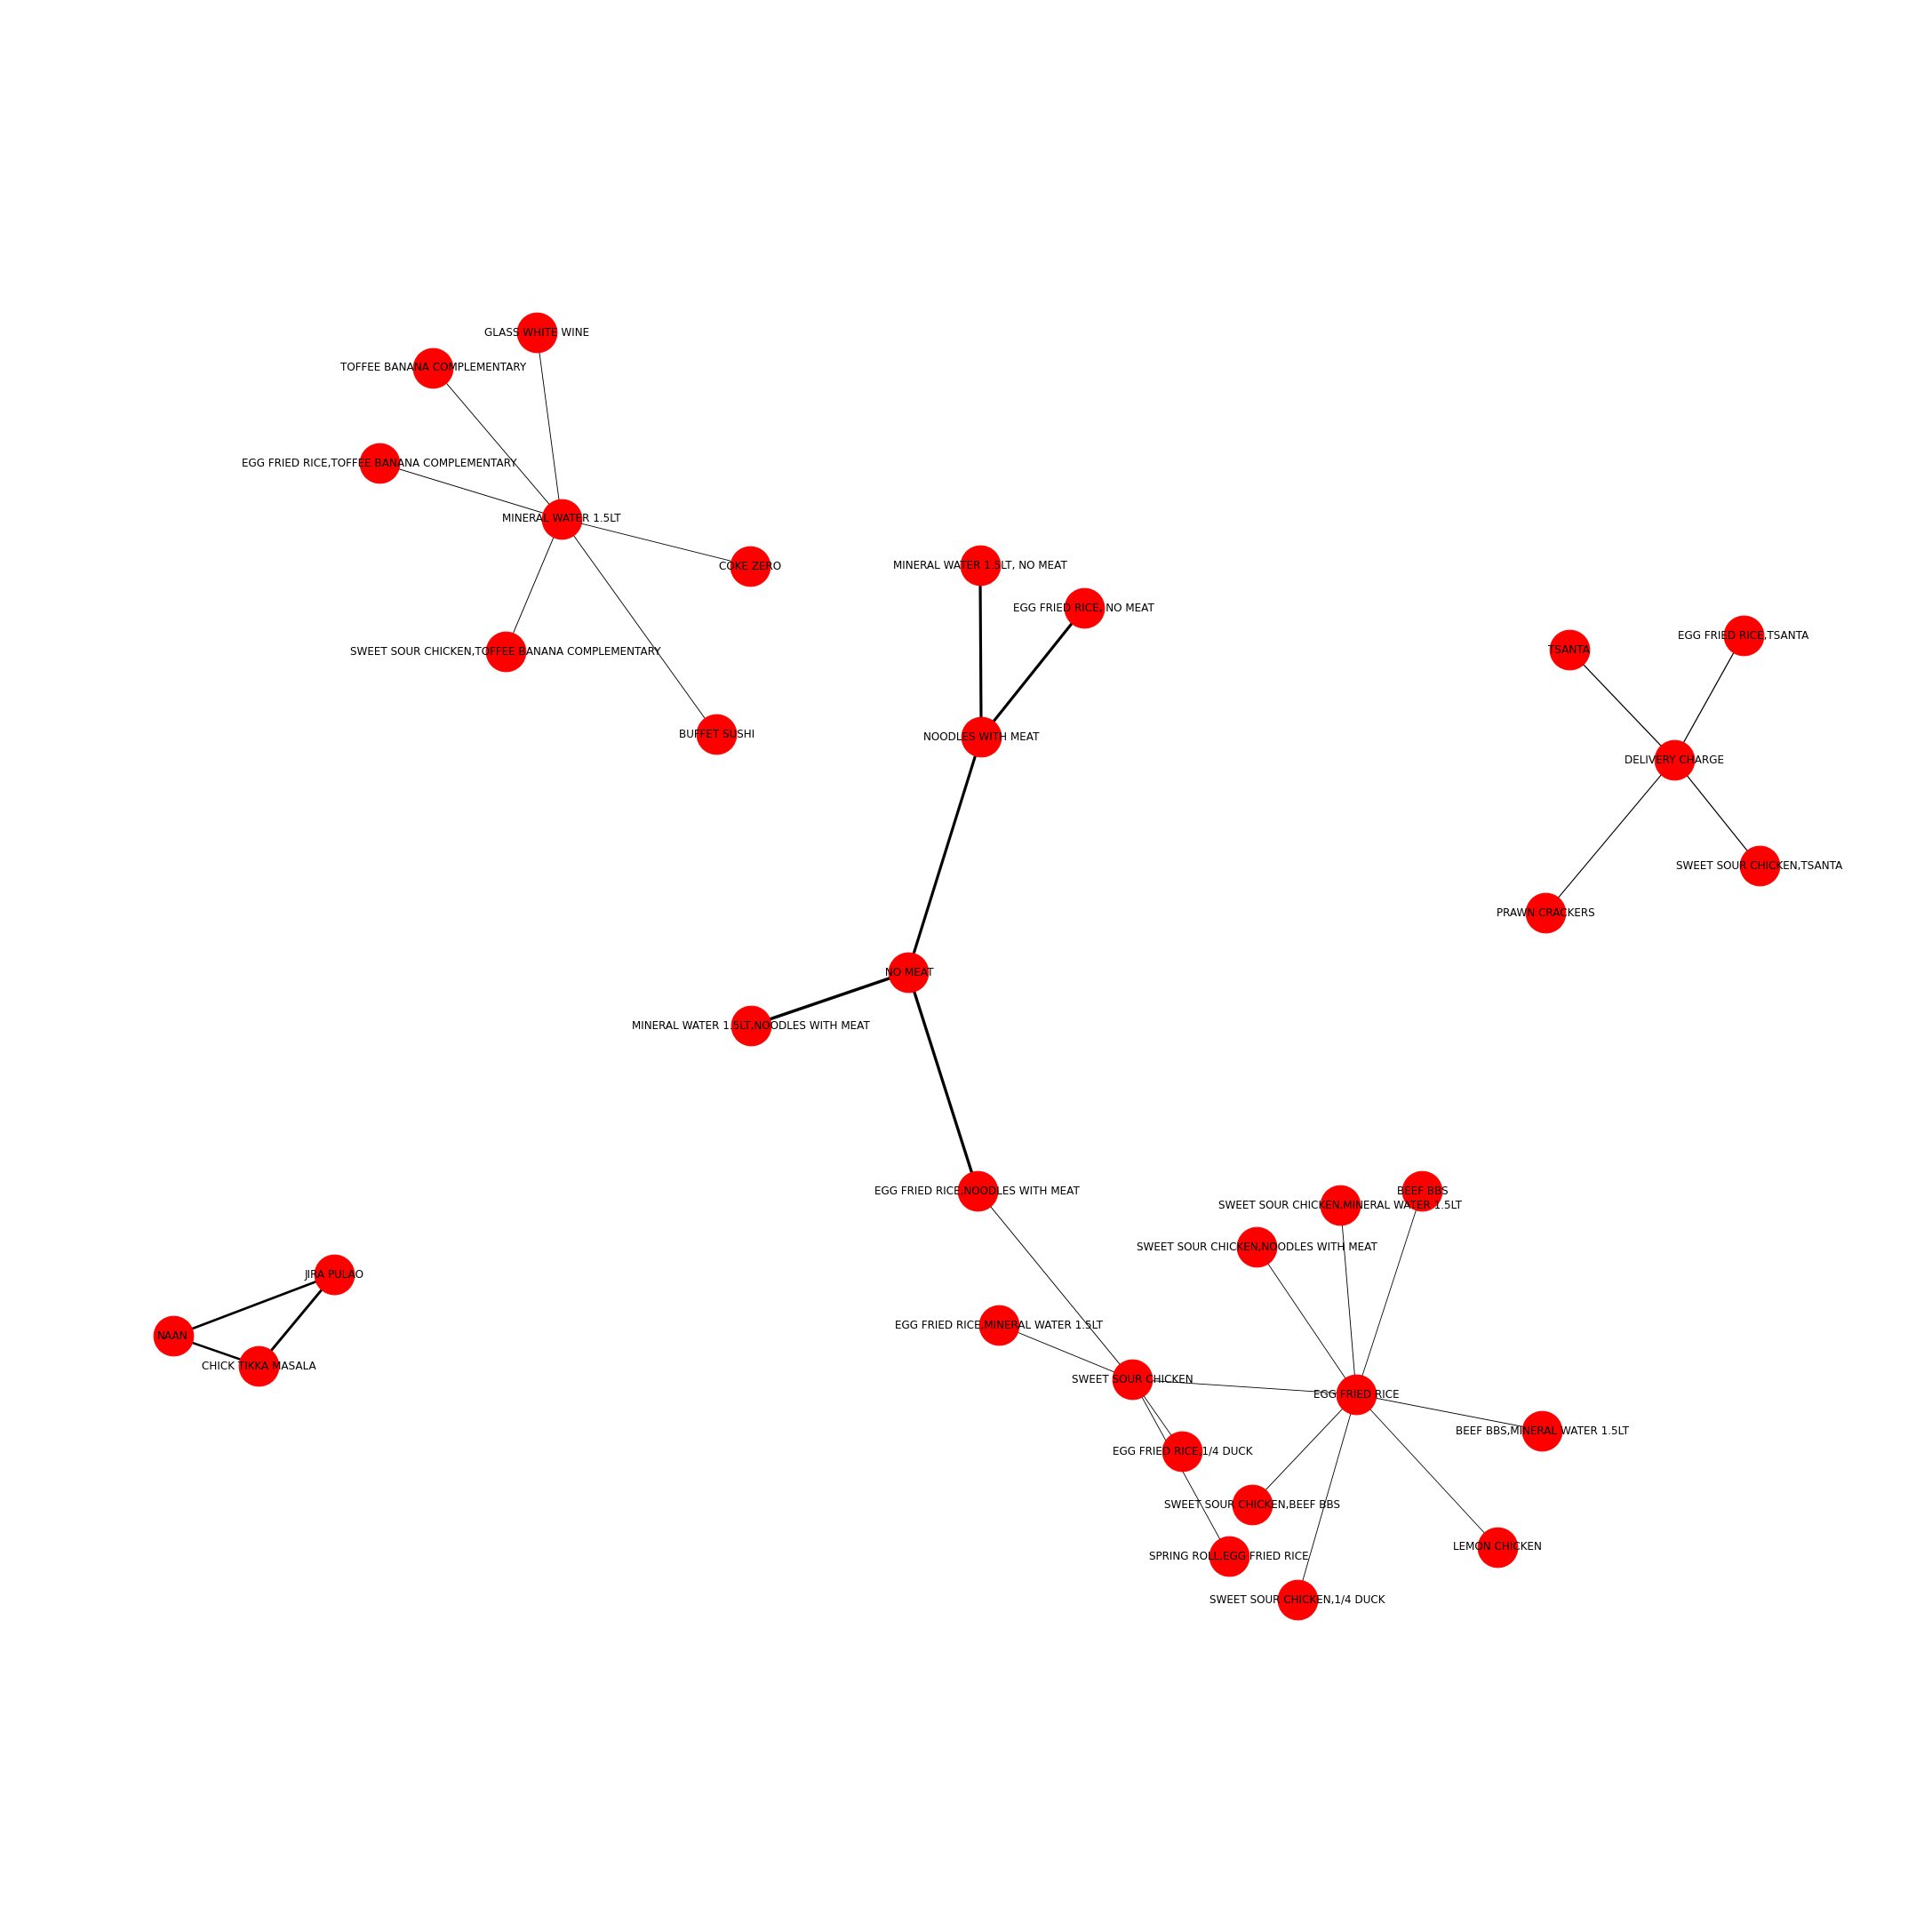

In [35]:
top_n = 30  # Display only the top 30 rules
rulesToPlot = rulesToPlot.nlargest(top_n, 'lift')
fig = plt.figure(figsize=(30, 30))  # Increase the figure size
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS', ['lift'])

# Set the edge width based on the lift value
edges = G.edges()
weights = [G[u][v]['lift'] for u, v in edges]
width = np.array(weights) * 0.5

# Customize node size, label font size, and layout
node_size = 2000
label_font_size = 12
pos = nx.spring_layout(G, k=0.3, seed=123)

nx.draw(G, pos, with_labels=True, node_size=node_size, node_color="red", width=width, font_size=label_font_size)
plt.axis('equal')
plt.show()

In [36]:
#Here we plotted an interactive network graph of the top 50 confidence rules, one can look up each anticident closely for better understanding

from pyvis.network import Network

rulesToPlot = rulesToPlot[:30]
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS', ['lift'])

# Initialize the interactive network graph
nt = Network(height='100%', width='100%', bgcolor='#FFFFFF', font_color='black', notebook=True)

# Add nodes and edges
for node in G.nodes():
    nt.add_node(node, label=node)

for edge in G.edges(data=True):
    nt.add_edge(edge[0], edge[1], value=edge[2]['lift'])

# Customize options
nt.options.configure = {'enabled': True}
nt.options.interaction.hover = True
nt.options.edges.width = 2
nt.options.edges.color = {'inherit': 'both'}

# Show the network graph
nt.show('network_graph.html')

network_graph.html


Location, Pax, weekday/weekend, time period (lunch, dinner)

# Suggestions based on different visualisations and findings

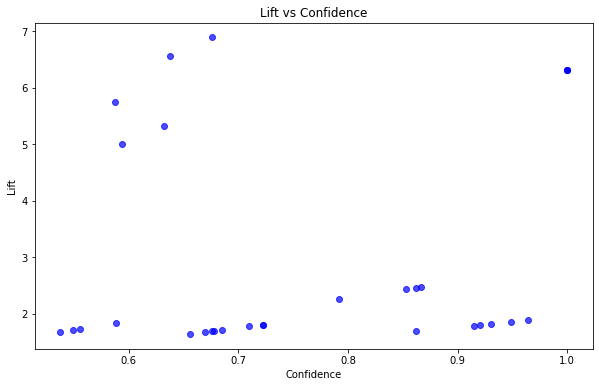

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(rulesToPlot['confidence'], rulesToPlot['lift'], alpha=0.7, c="blue")
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.title('Lift vs Confidence')
plt.show()

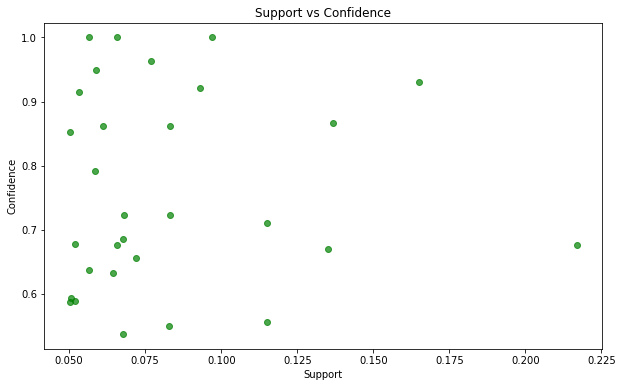

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(rulesToPlot['support'], rulesToPlot['confidence'], alpha=0.7, c="green")
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence')
plt.show()

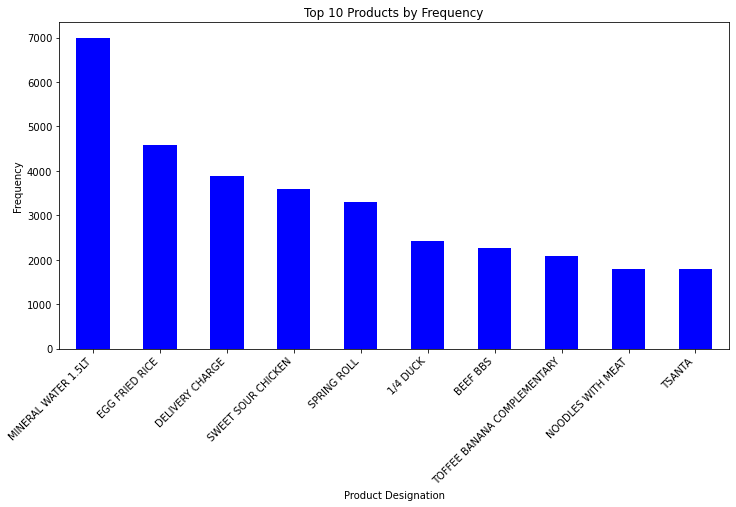

In [48]:
top_products = ds_1['ProductDesignation'].value_counts().head(10)
top_products.plot(kind='bar', figsize=(12, 6), color='blue')
plt.xlabel('Product Designation')
plt.ylabel('Frequency')
plt.title('Top 10 Products by Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

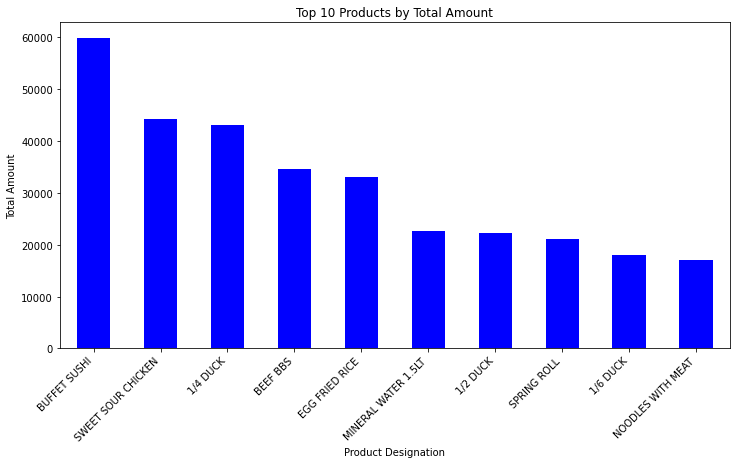

In [49]:
top_amount_products = ds_1.groupby('ProductDesignation')['TotalAmount'].sum().sort_values(ascending=False).head(10)
top_amount_products.plot(kind='bar', figsize=(12, 6), color='blue')
plt.xlabel('Product Designation')
plt.ylabel('Total Amount')
plt.title('Top 10 Products by Total Amount')
plt.xticks(rotation=45, ha='right')
plt.show()

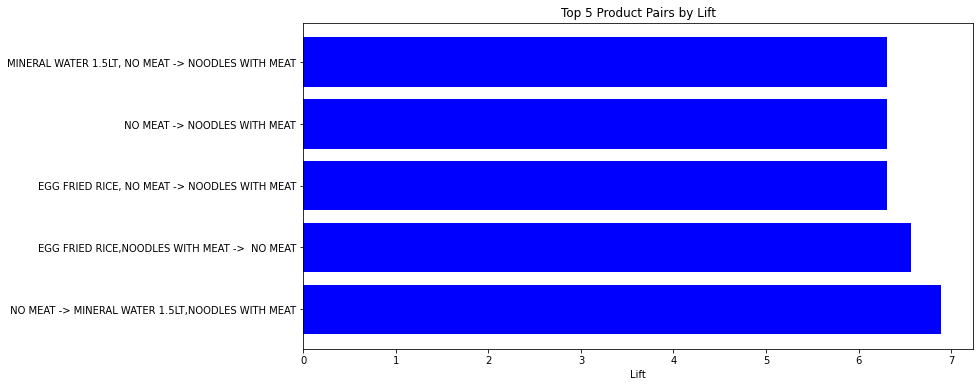

In [50]:
top_lift_pairs = rulesToPlot[['LHS', 'RHS', 'lift']].sort_values('lift', ascending=False).head(5)

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(range(top_lift_pairs.shape[0]), top_lift_pairs['lift'], color='blue')
ax.set_yticks(range(top_lift_pairs.shape[0]))
ax.set_yticklabels(["{} -> {}".format(lhs, rhs) for lhs, rhs in zip(top_lift_pairs['LHS'], top_lift_pairs['RHS'])])
plt.xlabel('Lift')
plt.title('Top 5 Product Pairs by Lift')
plt.show()

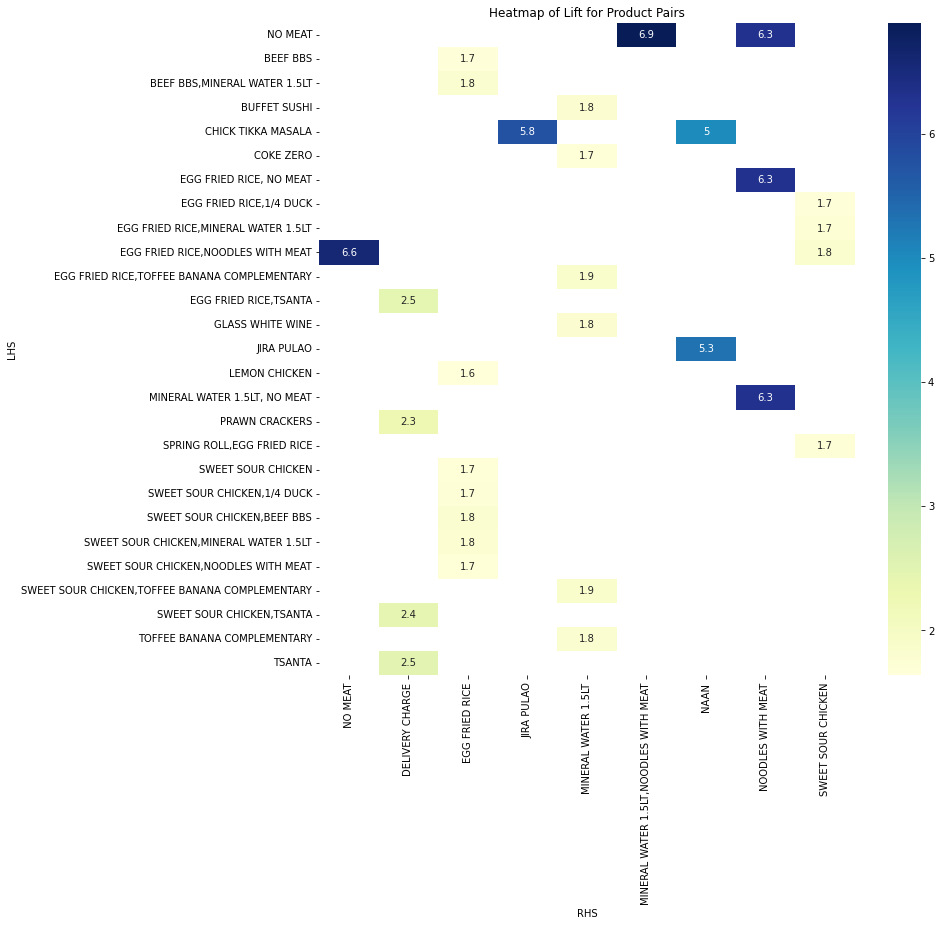

In [51]:
rulesToPlot['LHS'] = rulesToPlot['LHS'].astype(str)
rulesToPlot['RHS'] = rulesToPlot['RHS'].astype(str)

pivot_table = rulesToPlot.pivot_table(index='LHS', columns='RHS', values='lift')
plt.figure(figsize=(12, 12))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Heatmap of Lift for Product Pairs')
plt.show()

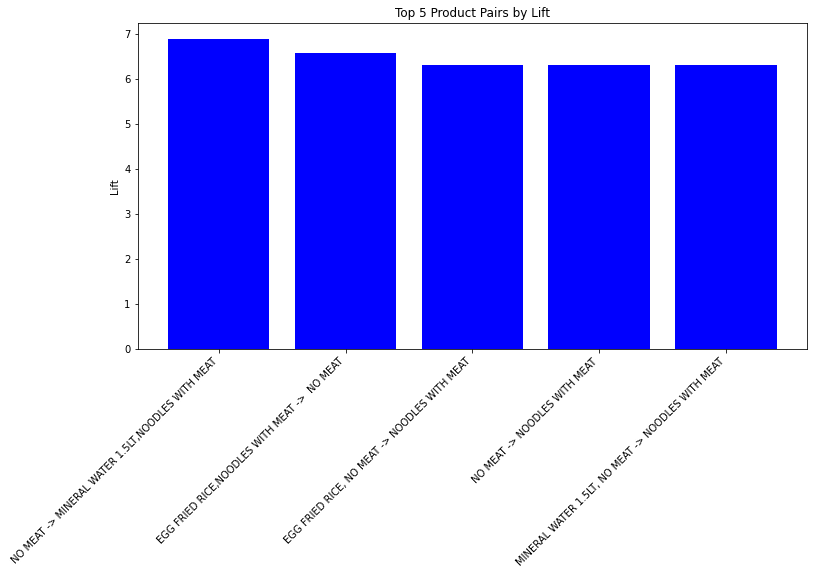

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(top_lift_pairs.shape[0]), top_lift_pairs['lift'], color='blue')
ax.set_xticks(range(top_lift_pairs.shape[0]))
ax.set_xticklabels(["{} -> {}".format(lhs, rhs) for lhs, rhs in zip(top_lift_pairs['LHS'], top_lift_pairs['RHS'])], rotation=45, ha='right')
plt.ylabel('Lift')
plt.title('Top 5 Product Pairs by Lift')
plt.show()

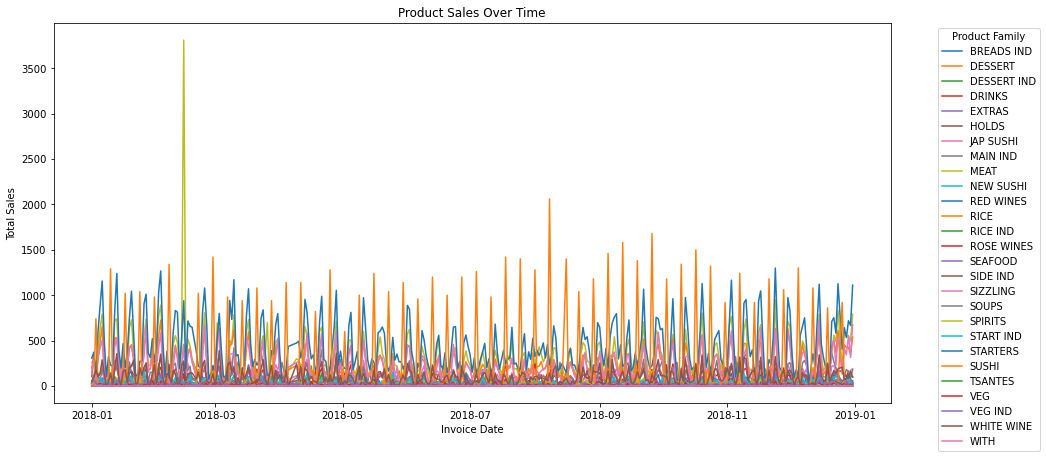

In [54]:
# Create a copy of the dataset
ds_1_copy = ds_1.copy()

# Extract date from InvoiceDateHour
ds_1_copy['InvoiceDate'] = ds_1_copy['InvoiceDateHour'].dt.date

# Group the data by date and ProductFamily and sum the TotalAmount
date_sales = ds_1_copy.groupby(['InvoiceDate', 'ProductFamily'])['TotalAmount'].sum().reset_index()

# Pivot the data to have a wide format suitable for a line chart
date_sales_pivot = date_sales.pivot_table(index='InvoiceDate', columns='ProductFamily', values='TotalAmount', fill_value=0)

# Create a line chart
ax = date_sales_pivot.plot(figsize=(15, 7))
ax.set_xlabel('Invoice Date')
ax.set_ylabel('Total Sales')
ax.set_title('Product Sales Over Time')
plt.legend(title='Product Family', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

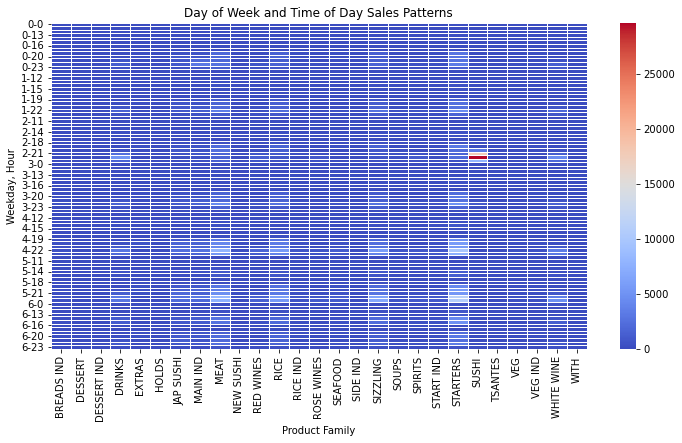

In [55]:
# Create a copy of the dataset
ds_1_copy = ds_1.copy()

# Extract day of the week and hour from InvoiceDateHour
ds_1_copy['weekday'] = ds_1_copy['InvoiceDateHour'].dt.weekday
ds_1_copy['hour'] = ds_1_copy['InvoiceDateHour'].dt.hour

# Group the data by weekday, hour, and ProductFamily, and sum the TotalAmount
weekday_hour_sales = ds_1_copy.groupby(['weekday', 'hour', 'ProductFamily'])['TotalAmount'].sum().reset_index()

# Create a pivot table with weekday and hour as indices and TotalAmount as values
weekday_hour_pivot = weekday_hour_sales.pivot_table(index=['weekday', 'hour'], columns='ProductFamily', values='TotalAmount', fill_value=0)

# Plot a heatmap using Seaborn
plt.figure(figsize=(12, 6))
sns.heatmap(weekday_hour_pivot, cmap='coolwarm', linewidths=0.5)
plt.xlabel('Product Family')
plt.ylabel('Weekday, Hour')
plt.title('Day of Week and Time of Day Sales Patterns')
plt.show()

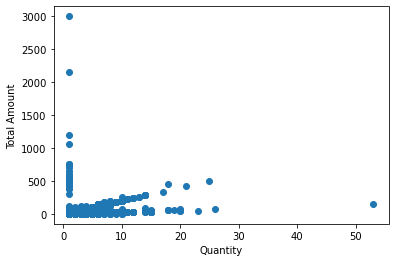

In [63]:
# plot the scatter plot
plt.scatter(ds['Qty'], ds['TotalAmount'])
plt.xlabel('Quantity')
plt.ylabel('Total Amount')
plt.show()

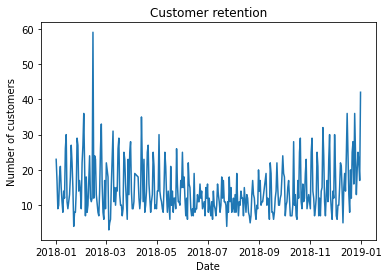

In [64]:
customer_retention = ds.groupby(ds.InvoiceDateHour.dt.date)['CustomerID'].nunique()
plt.plot(customer_retention.index, customer_retention.values)
plt.xlabel('Date')
plt.ylabel('Number of customers')
plt.title('Customer retention')
plt.show()

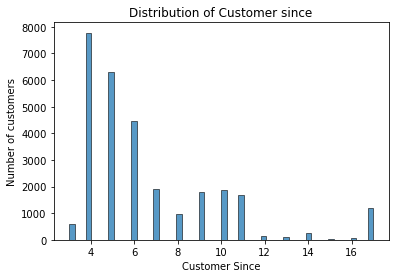

In [68]:
customer_age = (pd.Timestamp('now') - ds['CustomerSince']).astype('<m8[Y]')
sns.histplot(customer_age, kde=False)
plt.xlabel('Customer Since')
plt.ylabel('Number of customers')
plt.title('Distribution of Customer since')
plt.show()

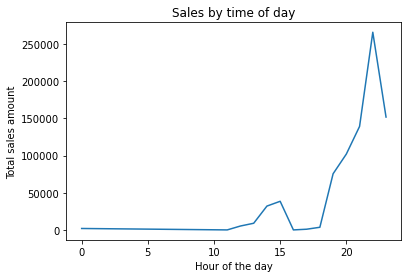

In [69]:
sales_by_hour = ds.groupby(ds.InvoiceDateHour.dt.hour)['TotalAmount'].sum()
plt.plot(sales_by_hour.index, sales_by_hour.values)
plt.xlabel('Hour of the day')
plt.ylabel('Total sales amount')
plt.title('Sales by time of day')
plt.show()

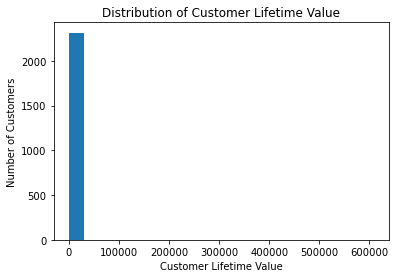

In [71]:
# Group by customer ID and calculate the total amount spent
customer_sales = ds.groupby('CustomerID')['TotalAmount'].sum()

# Calculate the number of visits per customer
customer_visits = ds.groupby('CustomerID')['DocNumber'].nunique()

# Calculate the average amount spent per visit
customer_avg_sales = customer_sales / customer_visits

# Calculate the customer lifetime value
customer_ltv = customer_avg_sales * customer_visits

# Create histogram
plt.hist(customer_ltv, bins=20)
plt.xlabel('Customer Lifetime Value')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Lifetime Value')
plt.show()

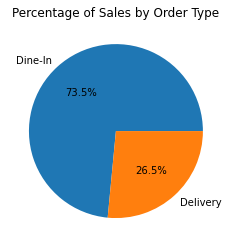

In [72]:
# Group by delivery vs dine-in and sum the total amount
delivery_sales = ds.groupby('IsDelivery')['TotalAmount'].sum()

# Create pie chart
plt.pie(delivery_sales.values, labels=['Dine-In', 'Delivery'], autopct='%1.1f%%')
plt.title('Percentage of Sales by Order Type')
plt.show()

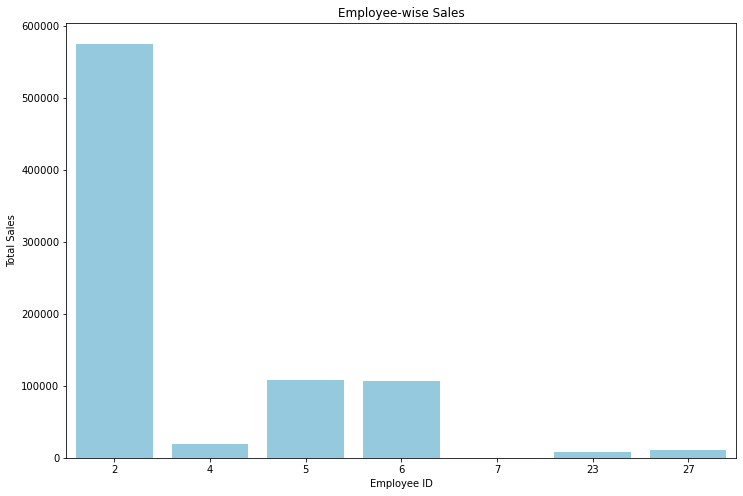

In [74]:
# employee-wise sales
employee_sales = ds.groupby('EmployeeID')['TotalAmount'].sum().reset_index()

# plot employee-wise sales
plt.figure(figsize=(12,8))
sns.barplot(x='EmployeeID', y='TotalAmount', data=employee_sales, color='skyblue')
plt.title('Employee-wise Sales')
plt.xlabel('Employee ID')
plt.ylabel('Total Sales')
plt.show()

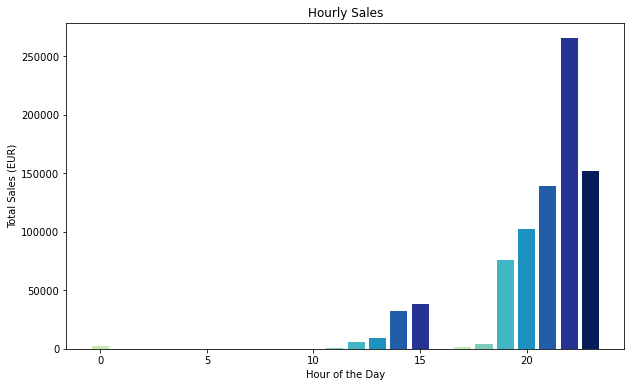

In [75]:
# calculate total sales by hour of the day
hourly_sales = ds.groupby(ds['InvoiceDateHour'].dt.hour)['TotalAmount'].sum()

# plot the bar chart with custom colors
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(hourly_sales.index, hourly_sales.values, color=['#C7E9B4', '#7FCDBB', '#41B6C4', '#1D91C0', '#225EA8', '#253494', '#081D58'])
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Total Sales (EUR)')
ax.set_title('Hourly Sales')
plt.show()


AttributeError: module 'matplotlib.pyplot' has no attribute 'DateFormatter'

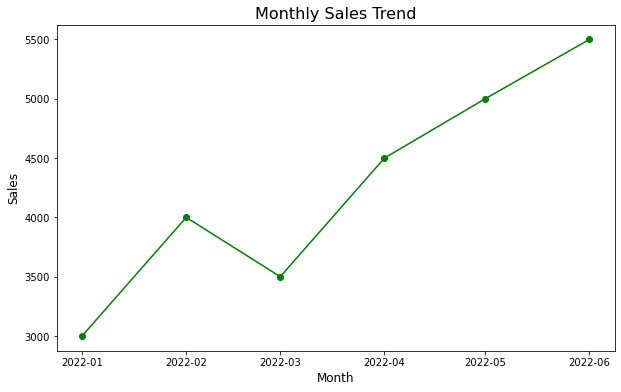

In [80]:
# create a dataframe with sales data
sales_data = {'Date': ['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01'],
              'Sales': [3000, 4000, 3500, 4500, 5000, 5500]}

df = pd.DataFrame(sales_data)

# convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# set Date column as index
df.set_index('Date', inplace=True)

# create line chart
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df.index, df['Sales'], color='green', marker='o')

# set chart title and axis labels
ax.set_title('Monthly Sales Trend', fontsize=16)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Sales', fontsize=12)

# set x-axis tick labels to show only month and year
ax.xaxis.set_major_formatter(plt.DateFormatter('%b %Y'))

# rotate x-axis tick labels for better readability
plt.xticks(rotation=45)

plt.show()


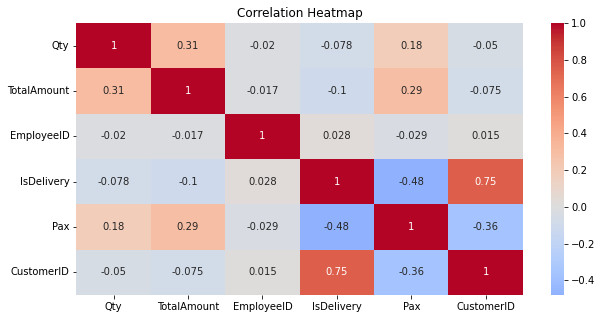

In [84]:
# Correlation heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(ds.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

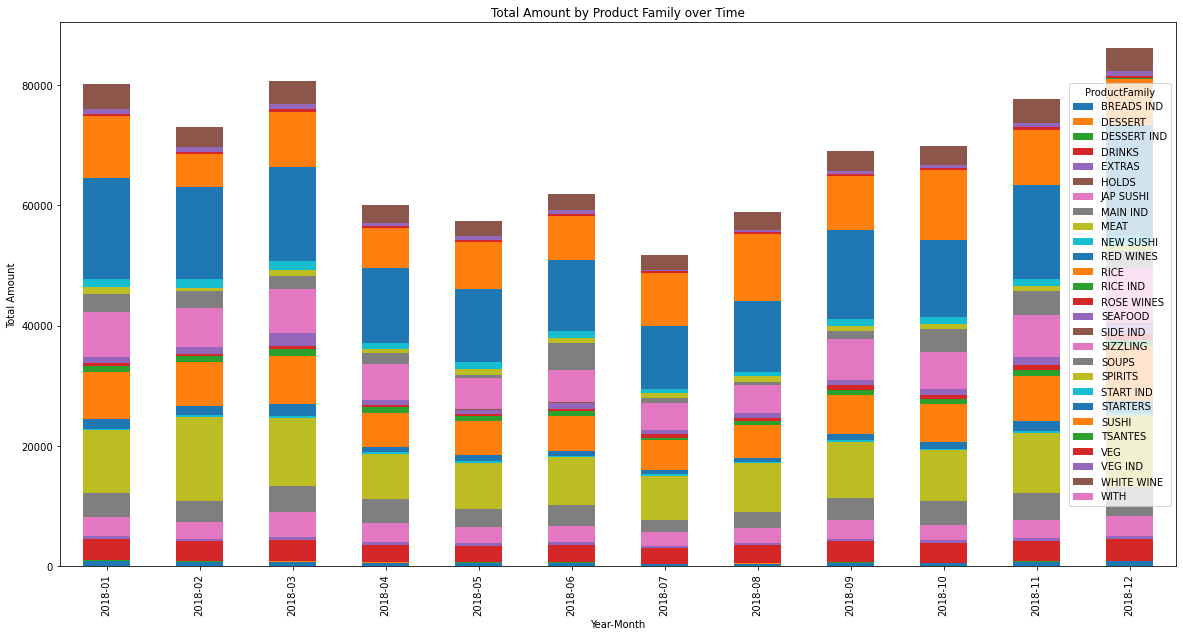

In [85]:
ds['year_month'] = pd.to_datetime(ds['InvoiceDateHour']).dt.to_period('M')
ds_grouped = ds.groupby(['year_month', 'ProductFamily'])['TotalAmount'].sum().unstack()
ds_grouped.plot(kind='bar', stacked=True, figsize=(20,10))
plt.title('Total Amount by Product Family over Time')
plt.xlabel('Year-Month')
plt.ylabel('Total Amount')
plt.show()

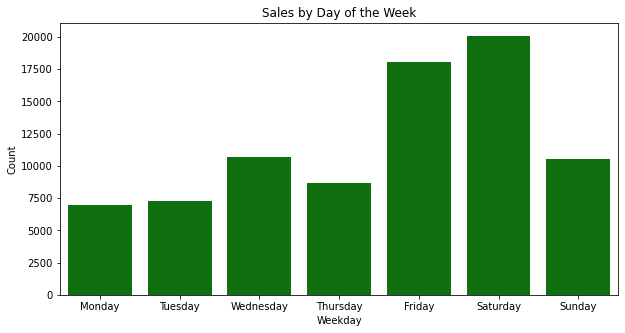

In [92]:
plt.figure(figsize=(10, 5))
sns.countplot(data=ds_1, x='weekday_name', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], color='green')
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.title('Sales by Day of the Week')
plt.show()

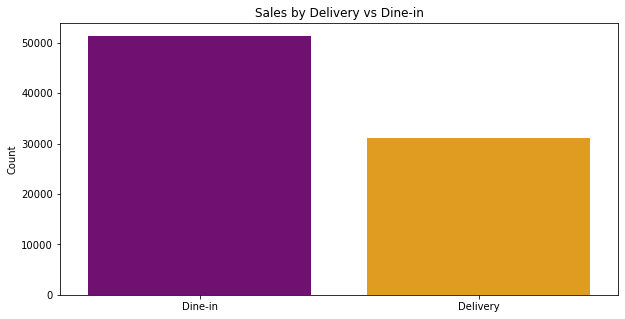

In [93]:
plt.figure(figsize=(10, 5))
sns.countplot(data=ds_1, x='IsDelivery', palette=['purple', 'orange'])
plt.xticks(ticks=[0, 1], labels=['Dine-in', 'Delivery'])
plt.xlabel('')
plt.ylabel('Count')
plt.title('Sales by Delivery vs Dine-in')
plt.show()

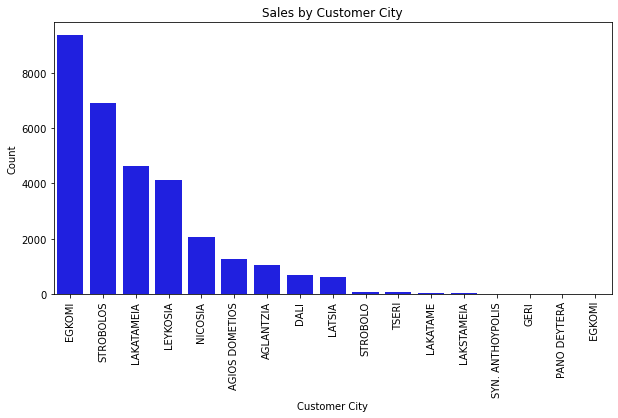

In [94]:
plt.figure(figsize=(10, 5))
sns.countplot(data=ds_1, x='CustomerCity', order=ds_1['CustomerCity'].value_counts().index, color='blue')
plt.xticks(rotation=90)
plt.xlabel('Customer City')
plt.ylabel('Count')
plt.title('Sales by Customer City')
plt.show()

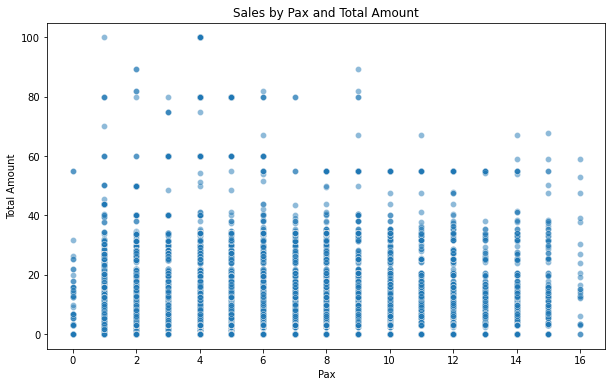

In [96]:
# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ds_1, x='Pax', y='TotalAmount', alpha=0.5)
plt.title('Sales by Pax and Total Amount')
plt.xlabel('Pax')
plt.ylabel('Total Amount')
plt.show()

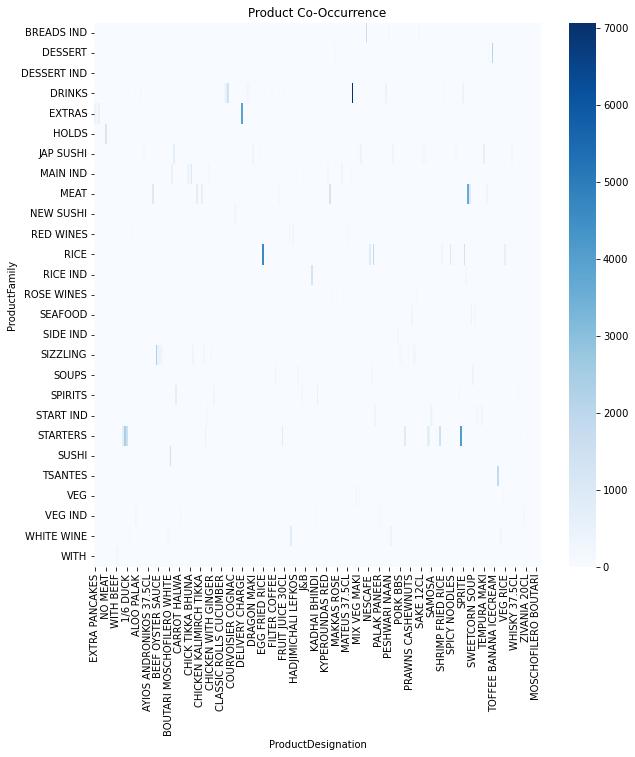

In [97]:
# Create a crosstab of product co-occurrences
product_crosstab = pd.crosstab(ds['ProductFamily'], ds['ProductDesignation'])

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(product_crosstab, cmap='Blues')
plt.title('Product Co-Occurrence')
plt.show()

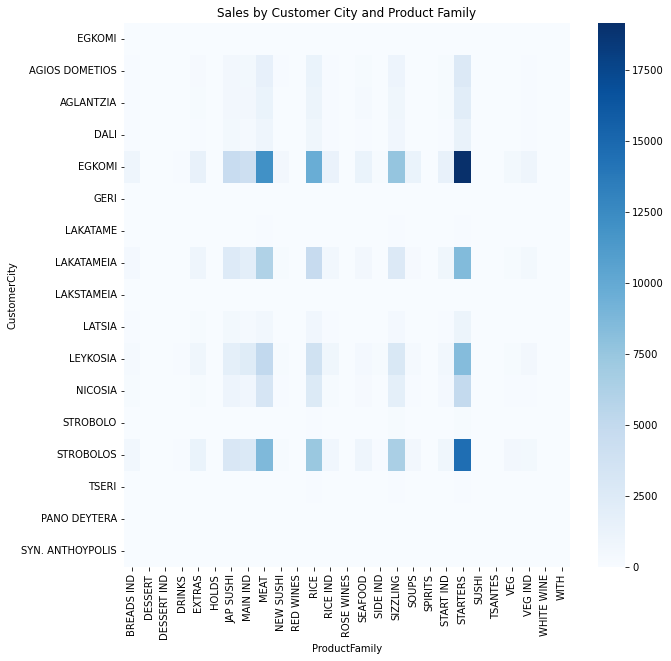

In [98]:
# Create a pivot table of sales by customer city and product family
sales_pivot = ds.pivot_table(index='CustomerCity', columns='ProductFamily', values='TotalAmount', aggfunc='sum')

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(sales_pivot, cmap='Blues')
plt.title('Sales by Customer City and Product Family')
plt.show()

In [ ]:
ds['CustomerSince'] = pd.to_datetime(ds['CustomerSince'], format='%Y-%m-%d')
sales_by_date = ds.groupby('CustomerSince')['TotalAmount'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=sales_by_date, x='CustomerSince', y='TotalAmount')
plt.title('Sales by Customer Since Date')
plt.xticks(rotation=45, ha='right')
plt.show()

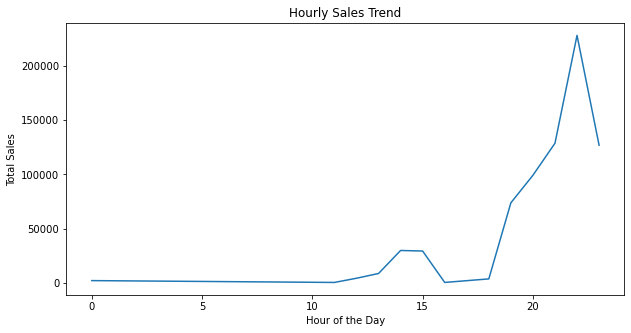

In [101]:
# Hourly Sales Trend
plt.figure(figsize=(10, 5))
ds_1.groupby(ds_1['InvoiceDateHour'].dt.hour)['TotalAmount'].sum().plot(kind='line')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Sales')
plt.title('Hourly Sales Trend')
plt.show()

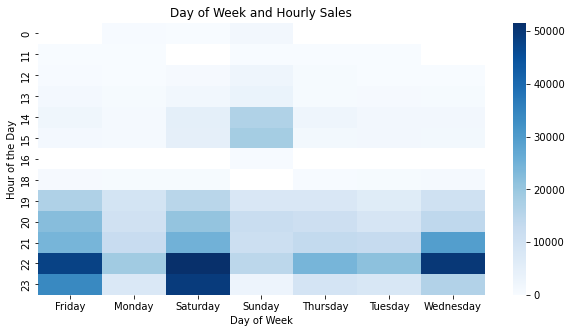

In [102]:
# Day of Week and Hourly Sales
plt.figure(figsize=(10, 5))
sales_by_hour = ds_1.pivot_table(index=ds_1['InvoiceDateHour'].dt.hour, columns=ds_1['weekday_name'], values='TotalAmount', aggfunc='sum')
sns.heatmap(sales_by_hour, cmap='Blues')
plt.xlabel('Day of Week')
plt.ylabel('Hour of the Day')
plt.title('Day of Week and Hourly Sales')
plt.show()

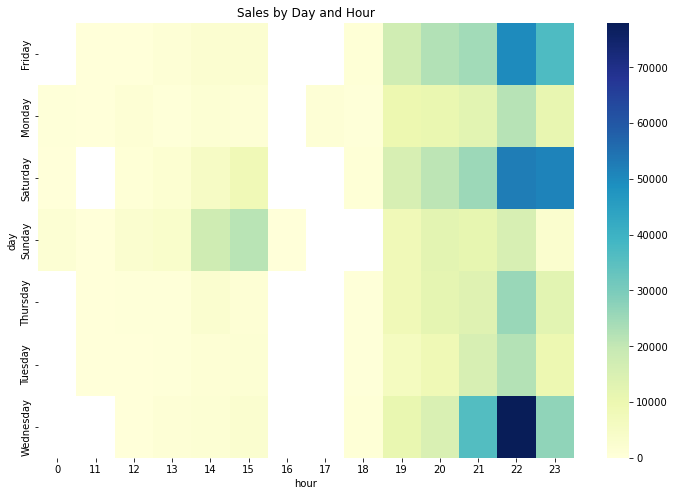

In [103]:
plt.figure(figsize=(12, 8))
ds['day'] = ds['InvoiceDateHour'].dt.day_name()
ds['hour'] = ds['InvoiceDateHour'].dt.hour
heatmap_data = ds.groupby(['day', 'hour'])['TotalAmount'].sum().reset_index()
heatmap_data = heatmap_data.pivot('day', 'hour', 'TotalAmount')
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title('Sales by Day and Hour')
plt.show()

C:\Users\PULSE Electronics\anaconda3\lib\site-packages\seaborn\distributions.py:385: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


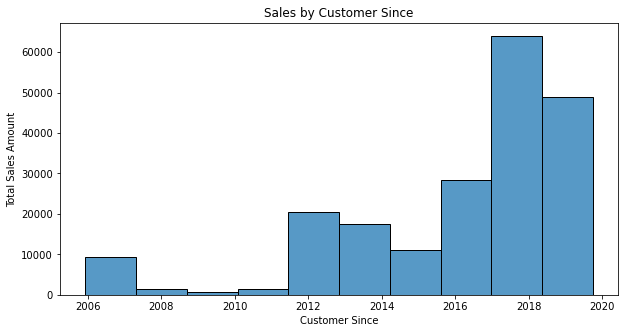

In [104]:
plt.figure(figsize=(10,5))
sns.histplot(data=ds, x='CustomerSince', weights=ds['TotalAmount'], kde=False)
plt.title('Sales by Customer Since')
plt.xlabel('Customer Since')
plt.ylabel('Total Sales Amount')
plt.show()

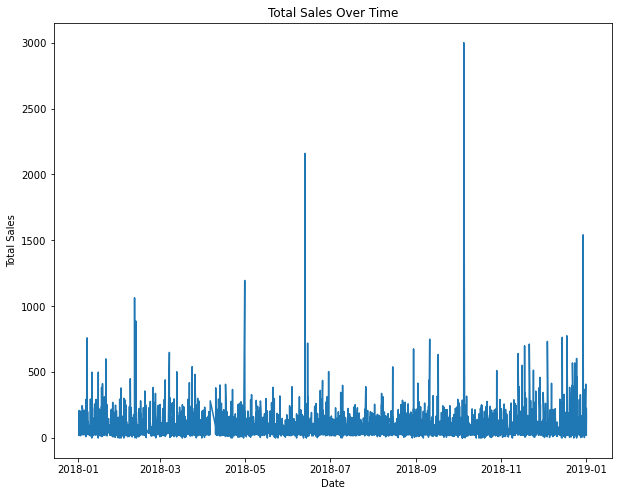

In [105]:
# Group sales by date
sales_by_date = ds.groupby('InvoiceDateHour')['TotalAmount'].sum().reset_index()

# Create a line chart
plt.figure(figsize=(10,8))
sns.lineplot(data=sales_by_date, x='InvoiceDateHour', y='TotalAmount')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

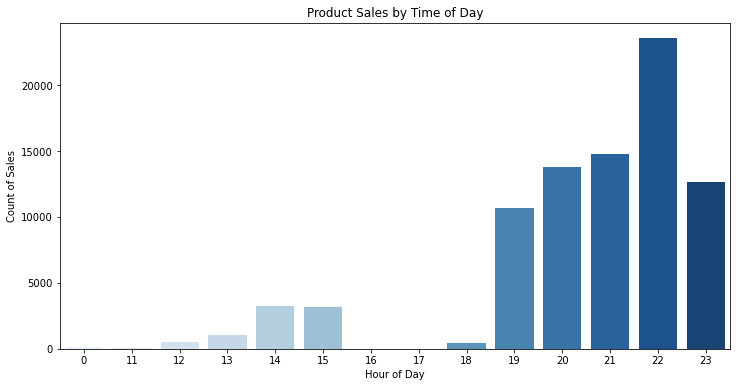

In [110]:
# Create a new column for hour of the day
ds['Hour'] = ds['InvoiceDateHour'].dt.hour

# Group by hour and calculate the count of sales
ds_hourly_sales = ds.groupby('Hour')['DocNumber'].count().reset_index()

# Plot the hourly sales
plt.figure(figsize=(12,6))
sns.barplot(x='Hour', y='DocNumber', data=ds_hourly_sales, palette='Blues')
plt.title('Product Sales by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Sales')
plt.show()

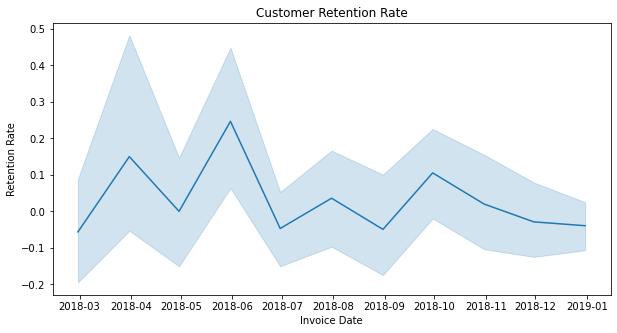

In [113]:
# Group the dataset by customer ID and invoice date
ds_grouped = ds.groupby(['CustomerID', pd.Grouper(key='InvoiceDateHour', freq='M')]).agg({'DocNumber': 'nunique'}).reset_index()
# Filter to include only customers with more than one invoice
ds_grouped = ds_grouped[ds_grouped['DocNumber'] > 1]
# Calculate the percentage of customers who made a repeat purchase within a month
ds_grouped['RetentionRate'] = ds_grouped.groupby('CustomerID')['DocNumber'].apply(lambda x: x.pct_change())

plt.figure(figsize=(10, 5))
sns.lineplot(data=ds_grouped, x='InvoiceDateHour', y='RetentionRate')
plt.title('Customer Retention Rate')
plt.xlabel('Invoice Date')
plt.ylabel('Retention Rate')
plt.show()

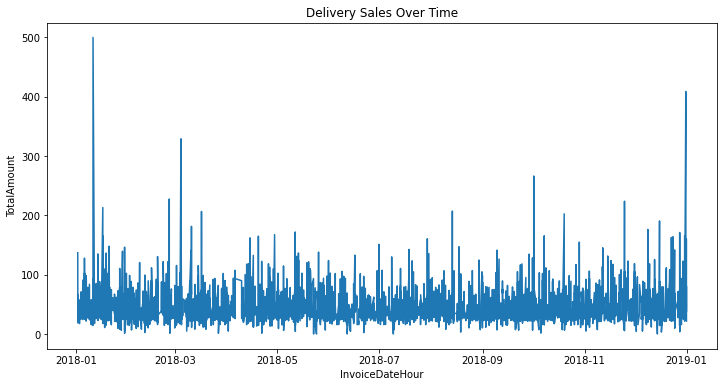

In [115]:
# Filter the dataset to include only delivery orders
ds_delivery = ds[ds['IsDelivery'] == 1]

# Group the data by the date of the invoice and sum the total amount
sales_by_date = ds_delivery.groupby('InvoiceDateHour').agg({'TotalAmount': 'sum'})

# Generate the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_by_date, x='InvoiceDateHour', y='TotalAmount')
plt.title('Delivery Sales Over Time')
plt.show()

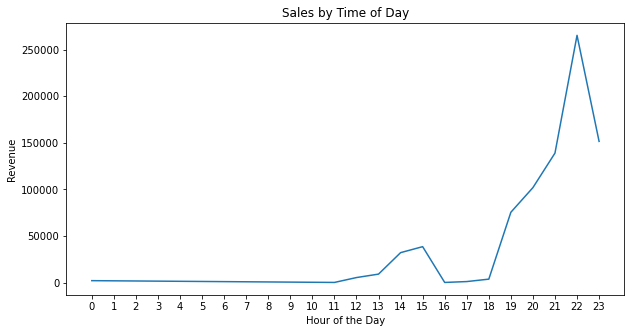

In [117]:
# Create a pivot table to calculate the total revenue by hour of the day
ds['hour'] = ds['InvoiceDateHour'].dt.hour
pivot_table = pd.pivot_table(ds, values='TotalAmount', index='hour', aggfunc='sum')

# Create a line chart of the revenue by hour of the day
plt.figure(figsize=(10, 5))
plt.plot(pivot_table.index, pivot_table['TotalAmount'])
plt.xticks(range(24))
plt.xlabel('Hour of the Day')
plt.ylabel('Revenue')
plt.title('Sales by Time of Day')
plt.show()

In [119]:
from geopy.geocoders import Nominatim

In [123]:
import folium

# Group the data by city and count the number of orders
city_counts = ds.groupby('CustomerCity')['DocNumber'].count().reset_index()
city_counts.rename(columns={'DocNumber': 'OrderCount'}, inplace=True)

# Sort by order count and keep the top 5 cities
city_counts = city_counts.sort_values(by='OrderCount', ascending=False).head(5)

# Create a map centered on Cyprus
cyprus_map = folium.Map(location=[35.1, 33.4], zoom_start=8)

# Add markers for each of the top cities
for i, row in city_counts.iterrows():
    city = row['CustomerCity']
    count = row['OrderCount']
    coords = get_coordinates(city)
    if coords:
        folium.Marker(location=coords, tooltip=f'{city}: {count} orders').add_to(cyprus_map)

# Display the map
cyprus_map

In [3]:
import plotly.graph_objects as go

# Group data by product family, delivery option and total amount
ds_grouped = ds.groupby(['ProductFamily', 'IsDelivery'])['TotalAmount'].sum().reset_index()

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = df_grouped['ProductFamily'].drop_duplicates(),
      color = 'blue'
    ),
    link = dict(
      source = df_grouped['ProductFamily'],
      target = df_grouped['IsDelivery'],
      value = df_grouped['TotalAmount']
  ))])

# Update layout
fig.update_layout(
    title='Flow of Sales by Product Family and Delivery',
    font=dict(size=12, color='black'),
    width=800,
    height=600
)

# Show figure
fig.show()

NameError: name 'ds' is not defined